# Example 1: Finding the habitable zone

In Section 6 of [Bixel & Apai (2021)](https://ui.adsabs.harvard.edu/abs/2021AJ....161..228B/abstract), we propose that the concept of a "habitable zone" could be validated by searching for a region of space where planets with atmospheric water vapor are statistically more frequent.

In this example, you will use Bioverse to determine whether a [LUVOIR](https://ui.adsabs.harvard.edu/abs/2019arXiv191206219T/abstract)-like imaging survey could test this hypothesis.

## Setup
First, we'll import the Bioverse code:

In [1]:
# Import numpy
import numpy as np

# Import the relevant modules
from bioverse.survey import ImagingSurvey
from bioverse.generator import Generator
from bioverse.hypothesis import Hypothesis
from bioverse import analysis

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20.

For this example, we will use the LUVOIR-like imaging survey and host star catalog.

In [2]:
generator = Generator('imaging')
survey = ImagingSurvey('default')

## Injecting the statistical effect

The first step is to inject the statistical effect we are searching for into the simulated planet population. Specifically, we will simulate the likelihood that a planet has atmospheric water vapor as follows:

In [3]:
def habitable_zone_water(d, f_water_habitable=0.75, f_water_nonhabitable=0.01):
    d['has_H2O'] = np.zeros(len(d),dtype=bool)

    # Non-habitable planets with atmospheres
    m1 = d['R'] > 0.8*d['S']**0.25
    d['has_H2O'][m1] = np.random.uniform(0,1,size=m1.sum()) < f_water_nonhabitable

    # exo-Earth candidates
    m2 = d['EEC']
    d['has_H2O'][m2] = np.random.uniform(0,1,size=m2.sum()) < f_water_habitable

    return d

generator.insert_step(habitable_zone_water)

Next, let's make a simulated dataset using this modified Generator object and the imaging Survey. Let's start with a relatively optimistic assumption that 75% of EECs are habitable and only 1% of non-EECs have "false positive" water vapor.

In [4]:
sample, detected, data = survey.quickrun(generator, f_water_habitable=0.75, f_water_nonhabitable=0.01)

Let's take a look at the simulated data set by plotting which planets have H2O versus their insolation. You might notice that planets within the habitable zone (approx 0.3 < S < 1.1) are more likely to have water-rich atmospheres.

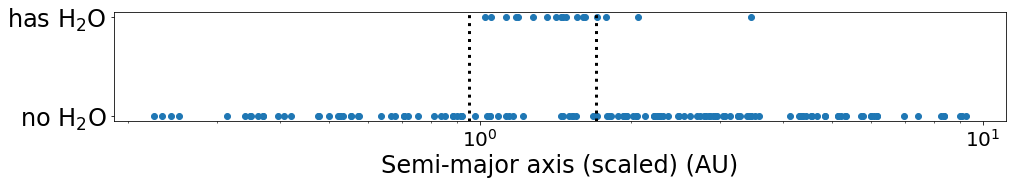

In [5]:
x, y = data['a_eff'], data['has_H2O']

# Now plot the water-rich/water-poor planets versus a_eff (in log-space)
fig, ax = plt.subplots(figsize=(16,2))
ax.scatter(x,y)
ax.set_xscale('log')
ax.set_yticks([0,1])
ax.set_yticklabels(['no H$_2$O','has H$_2$O'],fontsize=24)
ax.set_xlabel('Semi-major axis (scaled) (AU)',fontsize=24)

# Highlight the boundaries of the habitable zone (water-rich planets should be more common here)
ax.axvline(0.95,linestyle='dotted',c='black',lw=3)
ax.axvline(1.7,linestyle='dotted',c='black',lw=3)

plt.show()

The effect injected by `habitable_zone_water` is apparent in the dataset. But is this effect of high enough statistical significance to confirm the habitable zone hypothesis?

## Defining the hypothesis

Next, we'll create a new Hypothesis object representing the hypothesis that planets within one region of space are more likely to have atmospheric water vapor than those outside of it. Since we do not know the planets' sizes, the only independent variable is the distance from the star modulated by the stellar luminosity, called `a_eff` (this is already calculated). Likewise, the dependent variable is the presence or absence of water vapor, called `has_H2O`, which is either 0 or 1. The relationship between these values is parameterized by `a_inner` (the inner edge of the habitable zone in AU), `delta_a` (the width in AU), `f_HZ` (the fraction of HZ planets with H2O), and `df_notHZ` (the fraction of non-HZ planets with H2O *divided by* `f_HZ`). By defining the four parameters in this way, we can easily avoid parameter combinations inconsistent with our hypothesis (such as the fraction of non-HZ planets with H2O being higher than `f_HZ` planets).

In [6]:
# Define the hypothesis in functional form
def f(theta, X):
    a_inner, delta_a, f_HZ, df_notHZ = theta
    in_HZ = (X > a_inner) & (X < (a_inner + delta_a))
    return in_HZ * f_HZ + (~in_HZ) * f_HZ*df_notHZ

# Specify the names of the parameters (theta), features (X), and labels (Y)
params = ('a_inner', 'delta_a', 'f_HZ', 'df_notHZ')
features = ('a_eff',)
labels = ('has_H2O',)

In addition, we must consider the prior probability distribution of these parameters. Conservatively, we suppose the inner edge might extend far inward, or be slightly farther from the Sun than Earth, and that the HZ could be very narrow or very wide. Similarly, the fraction of planets with water vapor in the HZ and outside of it could span many orders of magnitude. We therefore choose to impose log-uniform prior distributions on these parameters across the following ranges:

0.1 < `a_inner` < 2 AU

0.01 < `delta_a` < 10 AU

0 < `f_HZ` < 1

0 < `f_notHZ` < 1

After deciding on the bounds, we can initialize the Hypothesis object.

In [7]:
bounds = np.array([[0.1, 2], [0.01, 10], [0.001, 1.0], [0.001, 1.0]])
h_HZ = Hypothesis(f, bounds, params=params, features=features, labels=labels, log=(True, True, True, True))

We also need to define the null hypothesis against which `h_HZ` is to be compared. The null hypothesis says that the fraction of planets with water vapor is independent of their orbits - this is a one parameter hypothesis where `f_H2O`, the fraction of planets with water vapor, is the only parameter. Again, the prior distribution on `f_H2O` should be broad (0 to 1) and log-uniform in shape. We can define this null hypothesis and attach it to `h_HZ` as follows:


In [8]:
def f_null(theta, X):
    shape = (np.shape(X)[0], 1)
    return np.full(shape, theta)
bounds_null = np.array([[0.001, 1.0]])
h_HZ.h_null = Hypothesis(f_null, bounds_null, params=('f_H2O',), features=features, labels=labels, log=(True,))


Now that the Hypothesis has been formed, we can formally test it using our simulated dataset. The `fit()` method will automatically extract the appropriate variables from the data and estimate the Bayesian evidence for both the hypothesis and null hypothesis using nested sampling. It will return the difference between the two i.e. the evidence in favor of the habitable zone hypothesis.

In [9]:
results = h_HZ.fit(data)
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.1E})".format(results['dlnZ'], np.exp(-results['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 13.1 (corresponds to p = 2.1E-06)


Generally speaking, a result where dlnZ > 3 is considered significant, so this was a succcessful test of the hypothesis.

**Note for iPython/Jupyter users:** We will need to reload the `generator` and `h_HZ` objects here to replace the ones you have defined above. These will produce the same results, but the next code block uses the `multiprocessing` module which is incompatible with functions defined in iPython.

In [10]:
# Reload `generator` and `h_HZ`
generator = Generator('imaging')
from bioverse.hypothesis import h_HZ


## Computing statistical power

We have not yet tackled the most uncertain part of this analysis: namely, just how common are habitable worlds? The fraction of Earth-sized planets in the habitable zone with atmospheric water vapor could far smaller than the assumed 75%, in which case it might be impossible to test the habitable zone hypothesis. To quantify the importance of this assumption, we will need to repeat the previous analysis several times with different values of `f_water_habitable`.

The `analysis` module enables this through its `test_hypothesis_grid()` function, which loops the planet simulation, survey simulation, and hypothesis test routines over a grid of input values. Let's use it to iterate over values of `f_water_habitable` ranging from 1% to 100%. For each value, we will repeat the analysis 20 times to average over Poisson noise.

This may take a few minutes. To speed things up, we will run 8 processes in parallel (you may need to change this number for an older CPU).

In [11]:
f_water_habitable = np.logspace(-2, 0, 10)
results = analysis.test_hypothesis_grid(h_HZ, generator, survey, f_water_habitable=f_water_habitable, t_total=10*365.25, processes=8, N=20)

100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


Now, let's plot the average Bayesian evidence for the hypothesis as a function of `f_water_habitable`.

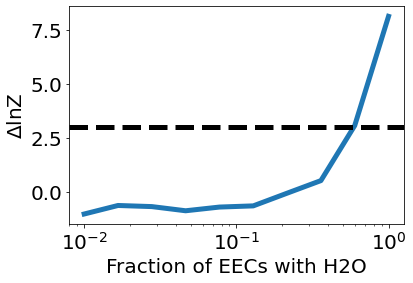

In [12]:
plt.plot(f_water_habitable, results['dlnZ'].mean(axis=-1), lw=5)
plt.xlabel('Fraction of EECs with H2O', fontsize=20)
plt.ylabel('$\Delta$lnZ', fontsize=20)
plt.axhline(3, lw=5, c='black', linestyle='dashed')
plt.xscale('log')

A more useful metric than the average Bayesian evidence is the survey's "statistical power", which is the likelihood that the survey could successfully test the hypothesis under a certain set of assumptions. Run this cell to plot the statistical power versus the fraction of EECs with water vapor.

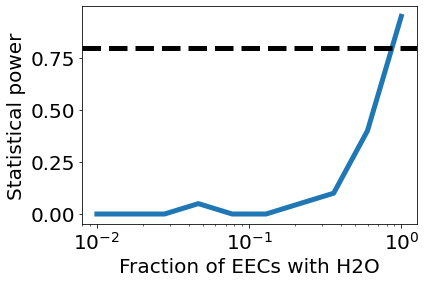

In [13]:
power = analysis.compute_statistical_power(results, method='dlnZ', threshold=3)
plt.plot(f_water_habitable, power, lw=5)
plt.xlabel('Fraction of EECs with H2O', fontsize=20)
plt.ylabel('Statistical power', fontsize=20)
plt.axhline(0.8, lw=5, c='black', linestyle='dashed')
plt.xscale('log')

We can see that a LUVOIR-like survey will be able to determine the existence of the habitable zone - but only if habitable planets are relatively common.